In [311]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [312]:
def switch_to_list(source_folders):
    result = []  

    folders = os.listdir(source_folders)

    for folder in folders:
        folder_images = []  
        
        folder_path = os.path.join(source_folders, folder)
        files = os.listdir(folder_path)
        
        for file in files:
            source_path = os.path.join(folder_path, file)
            
            
            img = cv2.imread(source_path)
            
            
            folder_images.append(img)
        
        
        result.append(folder_images)
    
    return result

In [313]:
def print_each_list(image_list, count, Cmap=None):
    fig, axes = plt.subplots(len(image_list), count, figsize=(count*3, len(image_list)*3))
    
    for i, images in enumerate(image_list):
        
        images_to_show = images[:count]
        
        for j, image in enumerate(images_to_show):
            
            axes[i, j].imshow(image, cmap=Cmap)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [314]:
def grayscale(img):
     result = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     return result

In [315]:
def sharpening(image):
    kernel = kernel = np.array([[-1, -1, -1],
                               [-1, 9, -1],
                               [-1, -1, -1]], dtype=np.float32)
    
    pad_size = kernel.shape[0] // 2
    gambar_input = np.pad(image, pad_size, mode='edge')

    gambar_konvolusi = np.zeros_like(image).astype(np.float32)

    baris, kolom = image.shape

    for i in range(baris):
        for j in range(kolom):

            gambar_konvolusi[i, j] = np.sum(gambar_input[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)

    # gambar_konvolusi = gambar_konvolusi.astype(np.uint8)

    return gambar_konvolusi

In [316]:
def smoothing(image):
    kernel = kernel = np.array([[1/10, 1/10, 1/10],
                             [1/10, 2/10, 1/10],
                             [1/10, 1/10, 1/10]], dtype=np.float32)
    
    pad_size = kernel.shape[0] // 2
    gambar_input = np.pad(image, pad_size, mode='edge')

    gambar_konvolusi = np.zeros_like(image).astype(np.float32)

    baris, kolom = image.shape

    for i in range(baris):
        for j in range(kolom):

            gambar_konvolusi[i, j] = np.sum(gambar_input[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)

    # gambar_konvolusi = gambar_konvolusi.astype(np.uint8)

    return gambar_konvolusi

In [317]:
def normalize_equal(matrix):
    arr = np.zeros(np.iinfo(matrix.dtype).max + 1)

    for i in matrix.flatten():
        arr[i] += 1

    for i in range(len(arr)):
        arr[i] /= len(matrix.flatten())
    return arr

def equalize(array):
    arr = np.zeros_like(array, dtype=array.dtype)

    modifier = 0

    for i in range(len(arr)):
        modifier += array[i]
        arr[i] = round(modifier * (len(arr) - 1))

    return arr

def equalize_matrix(matrix, array):
    mat = np.copy(matrix)

    for i, value in enumerate(matrix.flatten()):
        mat.flat[i] = array[value]
    
    return mat

def ekualisasi(img):
    normalisasi = normalize_equal(img)
    ekualisasi = equalize(normalisasi)
    gambar_ekualisasi = equalize_matrix(img, ekualisasi)
    return gambar_ekualisasi

In [318]:
def adjust_brightness(image):
    
    mean_val = np.mean(image)
    
    adjustment = 127 - mean_val
    
    if mean_val <= 127:
        adjusted_image = image + adjustment
    else:
        adjusted_image = image - (mean_val - 127)
    
    adjusted_image = np.clip(adjusted_image, 0, 255).astype(np.uint8)
    
    return adjusted_image

In [319]:
def min_max(img):
    image = np.copy(img)
    image_float = image.astype(np.float32)

    min_val = np.min(image_float)
    max_val = np.max(image_float)

    scaled_image = (image_float - min_val) / (max_val - min_val)

    scaled_image_uint8 = (scaled_image * 255).astype(np.uint8)

    return scaled_image_uint8

In [320]:
def otsu_threshold(image):

    hist, bins = np.histogram(image, bins=256, range=(0, 256))

    hist_norm = hist / hist.sum()

    best_thresh = 0
    best_variance = 0

    for t in range(256):

        q1 = hist_norm[:t+1].sum()
        q2 = hist_norm[t+1:].sum()
        if q1 == 0 or q2 == 0:
            continue
        m1 = np.sum(np.arange(0, t+1) * hist_norm[:t+1]) / q1
        m2 = np.sum(np.arange(t+1, 256) * hist_norm[t+1:]) / q2

        var_between = q1 * q2 * (m1 - m2) ** 2

        if var_between > best_variance:
            best_variance = var_between
            best_thresh = t

    return best_thresh

def manual_thresholding(image, threshold):

    binary_image = np.zeros_like(image)
    binary_image[image > threshold] = 1
    return binary_image

def remove_bg(image):
    result = np.copy(image)
    thresh = otsu_threshold(result)
    mask = manual_thresholding(result, thresh)
    masked_image = result * mask
    return masked_image

def segmentation(image):
    result = np.copy(image).astype(np.uint8)
    thresh = otsu_threshold(result)
    mask = manual_thresholding(result, thresh)
    return mask

def remove_bg(image):
    result = np.copy(image)
    thresh = otsu_threshold(result)
    mask = manual_thresholding(result, thresh)
    masked_image = result * mask
    return masked_image

def simple_thresholding(image):
    binary_image = np.zeros_like(image)
    binary_image[image > 0] = 1
    binary_image = binary_image.astype(np.uint8)
    return binary_image

In [321]:
def erosi(image, kernel = np.ones((3, 3), dtype=np.uint8)):
    
    pad_size = kernel.shape[0] // 2
    gambar_input = np.pad(image, pad_size, mode='constant')

    gambar_erosi = np.copy(image)

    baris, kolom = image.shape

    for i in range(baris):
        for j in range(kolom):

            slice_erosi = gambar_input[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel

            if not np.array_equal(slice_erosi, kernel):
                gambar_erosi[i, j] = 0

    return gambar_erosi

def dilasi(image, kernel = np.ones((3, 3), dtype=np.uint8)):
    
    pad_size = kernel.shape[0] // 2
    gambar_input = np.pad(image, pad_size, mode='constant')

    gambar_dilasi = np.zeros_like(image)

    baris, kolom = gambar_input.shape

    for i in range(pad_size, baris - pad_size):
        for j in range(pad_size, kolom - pad_size):

            slice_dilasi = gambar_input[i - pad_size:i - pad_size + kernel.shape[0], j - pad_size:j - pad_size + kernel.shape[1]]

    #         if image[i - pad_size, j - pad_size] == kernel[kernel.shape[0] // 2, kernel.shape[1] // 2]:
    #             slice_dilasi[kernel == 1] = 1
    #             gambar_dilasi[i - pad_size:i - pad_size + kernel.shape[0], j - pad_size:j - pad_size + kernel.shape[1]] = slice_dilasi

    # return gambar_dilasi[pad_size:gambar_input.shape[0] - pad_size, pad_size:gambar_input.shape[1] - pad_size]

            if np.any((slice_dilasi == 1) & (kernel == 1)):
                gambar_dilasi[i - pad_size, j - pad_size] = 1

    return gambar_dilasi

def opening(image):
    opening_img = erosi(image)
    opening_img = dilasi(opening_img)
    return opening_img

def closing(image):
    closing_img = dilasi(image)
    closing_img = erosi(closing_img)
    return closing_img

def gradien_morfologi(image):

    image_dilasi = dilasi(image)
    image_erosi = erosi(image)
    
    hasil_gradien = np.zeros_like(image_dilasi)
    
    for i in range (hasil_gradien.shape[0]):
        for j in range(hasil_gradien.shape[1]):
            
            if image_dilasi[i, j] == image_erosi[i, j]:
                hasil_gradien[i, j] = 0
            
            else: hasil_gradien[i, j] = 1
    
    return hasil_gradien

def rm_bg_gradien(image):
    edge_img = gradien_morfologi(image)
    thresh = otsu_threshold(edge_img)
    thresholded_img = manual_thresholding(edge_img.astype(np.uint8), thresh)
    bg_removed_img = image * (thresholded_img // 255)
    return bg_removed_img

def median_filter(image, y=3, x=3):
    padding_size = y // 2
    padded_arr = np.pad(image, padding_size, mode='edge')
    
    copy_arr = np.zeros_like(image).astype(np.float32)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            
            sorted_arr = np.sort((padded_arr[i:i + y, j:j + x] / (y * x)).flatten())
            # sorted_arr = np.sort((padded_arr[i:i + y, j:j + x]).flatten())
            copy_arr[i, j] = sorted_arr[(len(sorted_arr) - 1) // 2]
    
    return copy_arr

def edge_detection(gambar):

    kernel1 = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

    kernel2 = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

    if(kernel1.shape[0] == 3): gambar_input = np.pad(gambar, 1, mode='edge')
    
    else: gambar_input = np.pad(gambar, ((0, 1), (0, 1)), mode='edge')

    hasil = np.zeros_like(gambar).astype(np.float32)

    baris, kolom = gambar.shape

    for i in range(baris):
        for j in range(kolom):

            konvo_x = np.sum(gambar_input[i:i + kernel1.shape[0], j:j + kernel1.shape[1]] * kernel1)
            konvo_y = np.sum(gambar_input[i:i + kernel2.shape[0], j:j + kernel2.shape[1]] * kernel2)
            
            magnitudo = np.sqrt(np.power(konvo_x, 2) + np.power(konvo_y, 2)).astype(hasil.dtype)
            
            hasil[i, j] = magnitudo

    return hasil

In [322]:
def preprocess(image_list):
    result = []
    
    for images in image_list:
        sub_result = []
        
        for img in images:
            
            processed_img = grayscale(img)

            processed_img = adjust_brightness(processed_img) #

            processed_img = sharpening(processed_img) #4

            processed_img = median_filter(processed_img)

            processed_img = edge_detection(processed_img) #

            processed_img = min_max(processed_img) #
            
            # processed_img = rm_bg_gradien(processed_img) #3 

            # processed_img = gradien_morfologi(processed_img) #

            # processed_img = opening(processed_img) #
            # processed_img = closing(processed_img) #
            
            sub_result.append(processed_img)
        
        result.append(sub_result)
    
    return result

In [323]:
def calculate_glcm(img, distances, angles):
    max_gray_level = 256
    glcm = np.zeros((max_gray_level, max_gray_level, len(distances), len(angles)), dtype=np.float64)
    rows, cols = img.shape

    for d, distance in enumerate(distances):
        for a, angle in enumerate(angles):
            dx = int(np.round(np.cos(angle) * distance))
            dy = int(np.round(np.sin(angle) * distance))
            
            for i in range(rows):
                for j in range(cols):
                    new_i = i + dy
                    new_j = j + dx
                    if 0 <= new_i < rows and 0 <= new_j < cols:
                        glcm[img[i, j], img[new_i, new_j], d, a] += 1

    glcm /= np.sum(glcm, axis=(0, 1), keepdims=True)
    return glcm

def extract_features(glcm):
    features = {}
    num_levels = glcm.shape[0]
    
    mean_i = np.sum(np.arange(num_levels)[:, None] * glcm, axis=(0, 1))
    mean_j = np.sum(np.arange(num_levels)[None, :] * glcm, axis=(0, 1))
    std_i = np.sqrt(np.sum((np.arange(num_levels)[:, None] - mean_i) ** 2 * glcm, axis=(0, 1)))
    std_j = np.sqrt(np.sum((np.arange(num_levels)[None, :] - mean_j) ** 2 * glcm, axis=(0, 1)))

    features['contrast'] = np.sum((np.arange(num_levels)[:, None] - np.arange(num_levels)[None, :]) ** 2 * glcm, axis=(0, 1))
    features['dissimilarity'] = np.sum(np.abs(np.arange(num_levels)[:, None] - np.arange(num_levels)[None, :]) * glcm, axis=(0, 1))
    features['homogeneity'] = np.sum(glcm / (1.0 + (np.arange(num_levels)[:, None] - np.arange(num_levels)[None, :]) ** 2), axis=(0, 1))
    features['energy'] = np.sqrt(np.sum(glcm ** 2, axis=(0, 1)))
    features['correlation'] = np.sum((np.arange(num_levels)[:, None] * np.arange(num_levels)[None, :] * glcm - mean_i * mean_j) / (std_i * std_j), axis=(0, 1))
    features['entropy'] = -np.sum(glcm * np.log2(glcm + (glcm == 0)), axis=(0, 1))
    features['asm'] = np.sum(glcm ** 2, axis=(0, 1))

    return features

def extract_features_glcm(grayscale_images, distances=[1, 2, 3, 4, 5], labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
):
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]  # 0, 45, 90, dan 135 derajat dalam satuan radian
    features_list = []

    for folder_index, folder_images in enumerate(grayscale_images):
        for img in folder_images:
            # img_features = []
            glcm = calculate_glcm(img, distances, angles)
            
            
            for d in range(len(distances)):
                features_at_angle = {}
                
                for a in range(len(angles)):
                    features = extract_features(glcm[:, :, d, a])
                    for key, value in features.items():
                        features_at_angle[f'{key}_{int(np.degrees(angles[a]))}'] = value
                features_at_angle['label'] = labels[folder_index]
                features_list.append(features_at_angle)
                
            
            
            # img_features.append(features_at_angle)
            # features_list.append(features_at_angle)
    
    return features_list

In [324]:
the_folders = 'E:/kuliah/semester 4/pengolahan citra digital/praktikum/projek/just use this'

In [325]:
the_list = switch_to_list(the_folders)

In [326]:
# print_each_list(the_list, 4)

In [327]:
preprocessed_list = preprocess(the_list)

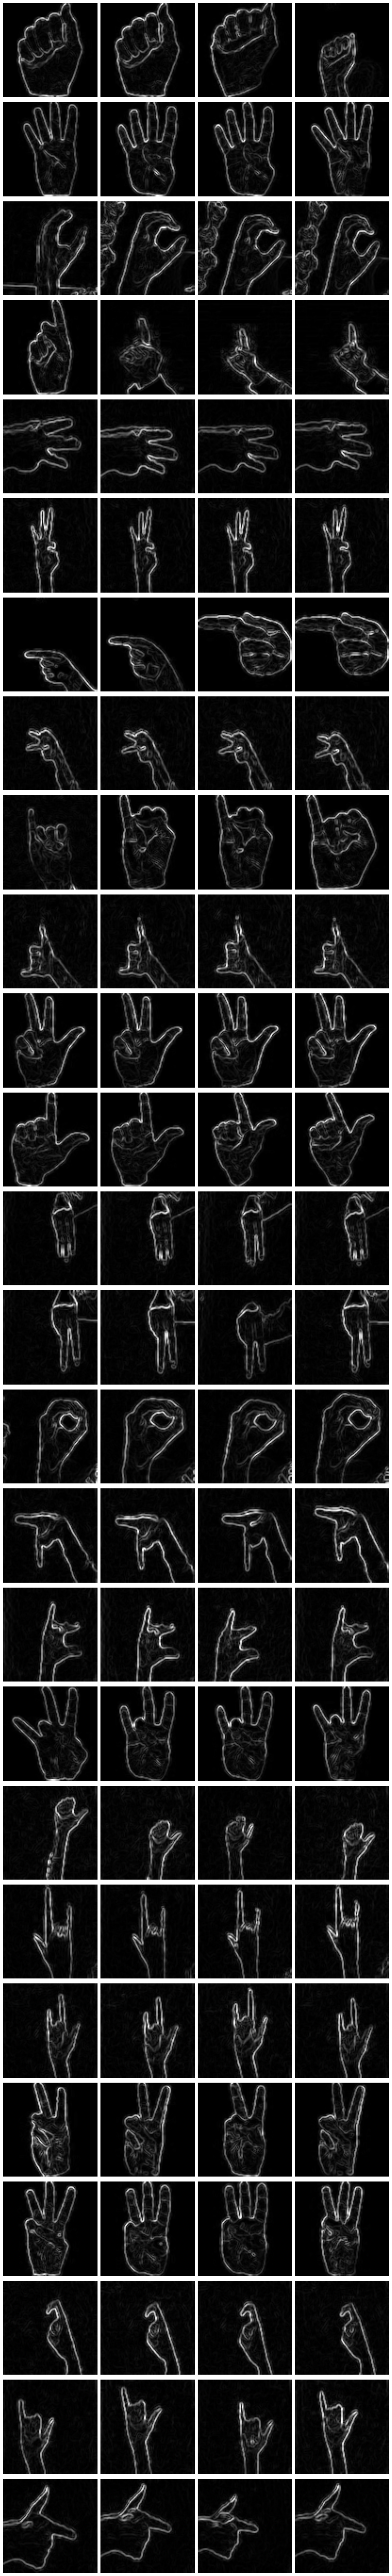

In [328]:
print_each_list(preprocessed_list, 4, "gray")

In [329]:
glcm_features = extract_features_glcm(preprocessed_list)

In [330]:
features_df = pd.DataFrame(glcm_features)

In [331]:
features_df.head(10)

contrast_0  dissimilarity_0  homogeneity_0  energy_0  correlation_0  \
0   542.224848         9.665859       0.475528  0.353432  -16860.375725   
1  1086.774694        15.033061       0.431440  0.335499  -17077.509146   
2  1325.670103        17.350103       0.405771  0.320051  -17300.153605   
3  1570.787188        19.326979       0.386637  0.304207  -17528.276582   
4  1707.643789        20.760421       0.363395  0.290147  -17761.913495   
5   634.868485        10.425455       0.476916  0.362661  -16826.724343   
6  1288.331224        16.301429       0.433001  0.343085  -17043.351634   
7  1549.151753        18.692990       0.409653  0.327439  -17265.454179   
8  1813.346458        20.766458       0.386603  0.312130  -17492.915084   
9  1983.727895        22.087684       0.371989  0.298390  -17724.768516   

   entropy_0     asm_0  contrast_45  dissimilarity_45  homogeneity_45  ...  \
0   7.424823  0.124914   823.957045         12.034588        0.455338  ...   
1   7.727623  0.112559   823.957045         12.034588        0.455338  ...   
2   7.954395  0.102433  1424.206372         17.513953        0.418540  ...   
3   8.163553  0.092542  1738.814220         20.032628        0.388308  ...   
4   8.305834  0.084185  1914.863281         21.713325        0.367822  ...   
5   7.415243  0.131523   951.098867         12.903581        0.459718  ...   
6   7.744949  0.117707   951.098867         12.903581        0.459718  ...   
7   7.965602  0.107216  1641.187318         18.774781        0.420136  ...   
8   8.153941  0.097425  1998.441598         21.471676        0.394270  ...   
9   8.302014  0.089037  2170.951497         23.059353        0.370954  ...   

   entropy_90    asm_90  contrast_135  dissimilarity_135  homogeneity_135  \
0    7.233156  0.133328    696.765942          11.237323         0.456826   
1    7.476714  0.127006    696.765942          11.237323         0.456826   
2    7.603256  0.122514   1211.996876          16.085173         0.419753   
3    7.720852  0.117953   1503.613668          18.575088         0.396182   
4    7.798544  0.113570   1668.993490          20.202908         0.373276   
5    7.241862  0.139070    775.921028          11.774921         0.457202   
6    7.491313  0.131226    775.921028          11.774921         0.457202   
7    7.627201  0.126119   1348.828092          16.893898         0.423061   
8    7.723499  0.121758   1665.354767          19.491657         0.394068   
9    7.821645  0.117137   1835.779188          21.097765         0.375090   

   energy_135  correlation_135  entropy_135   asm_135  label  
0    0.348984    -16928.887950     7.509530  0.121790      A  
1    0.348984    -16928.887950     7.509530  0.121790      A  
2    0.330328    -17401.089270     7.811092  0.109117      A  
3    0.311871    -17639.936355     8.045155  0.097263      A  
4    0.295011    -17926.034880     8.239946  0.087032      A  
5    0.357037    -16888.921009     7.518689  0.127475      A  
6    0.357037    -16888.921009     7.518689  0.127475      A  
7    0.336505    -17222.003141     7.829655  0.113235      A  
8    0.316652    -17458.349809     8.064003  0.100268      A  
9    0.297914    -17759.749621     8.277292  0.088753      A  

[10 rows x 29 columns]

In [332]:
# features_df.to_csv('2.2_ekstraksi_fitur_setelah.csv', index=False)

In [333]:
# features_df = pd.read_csv('2.2_ekstraksi_fitur_setelah.csv')

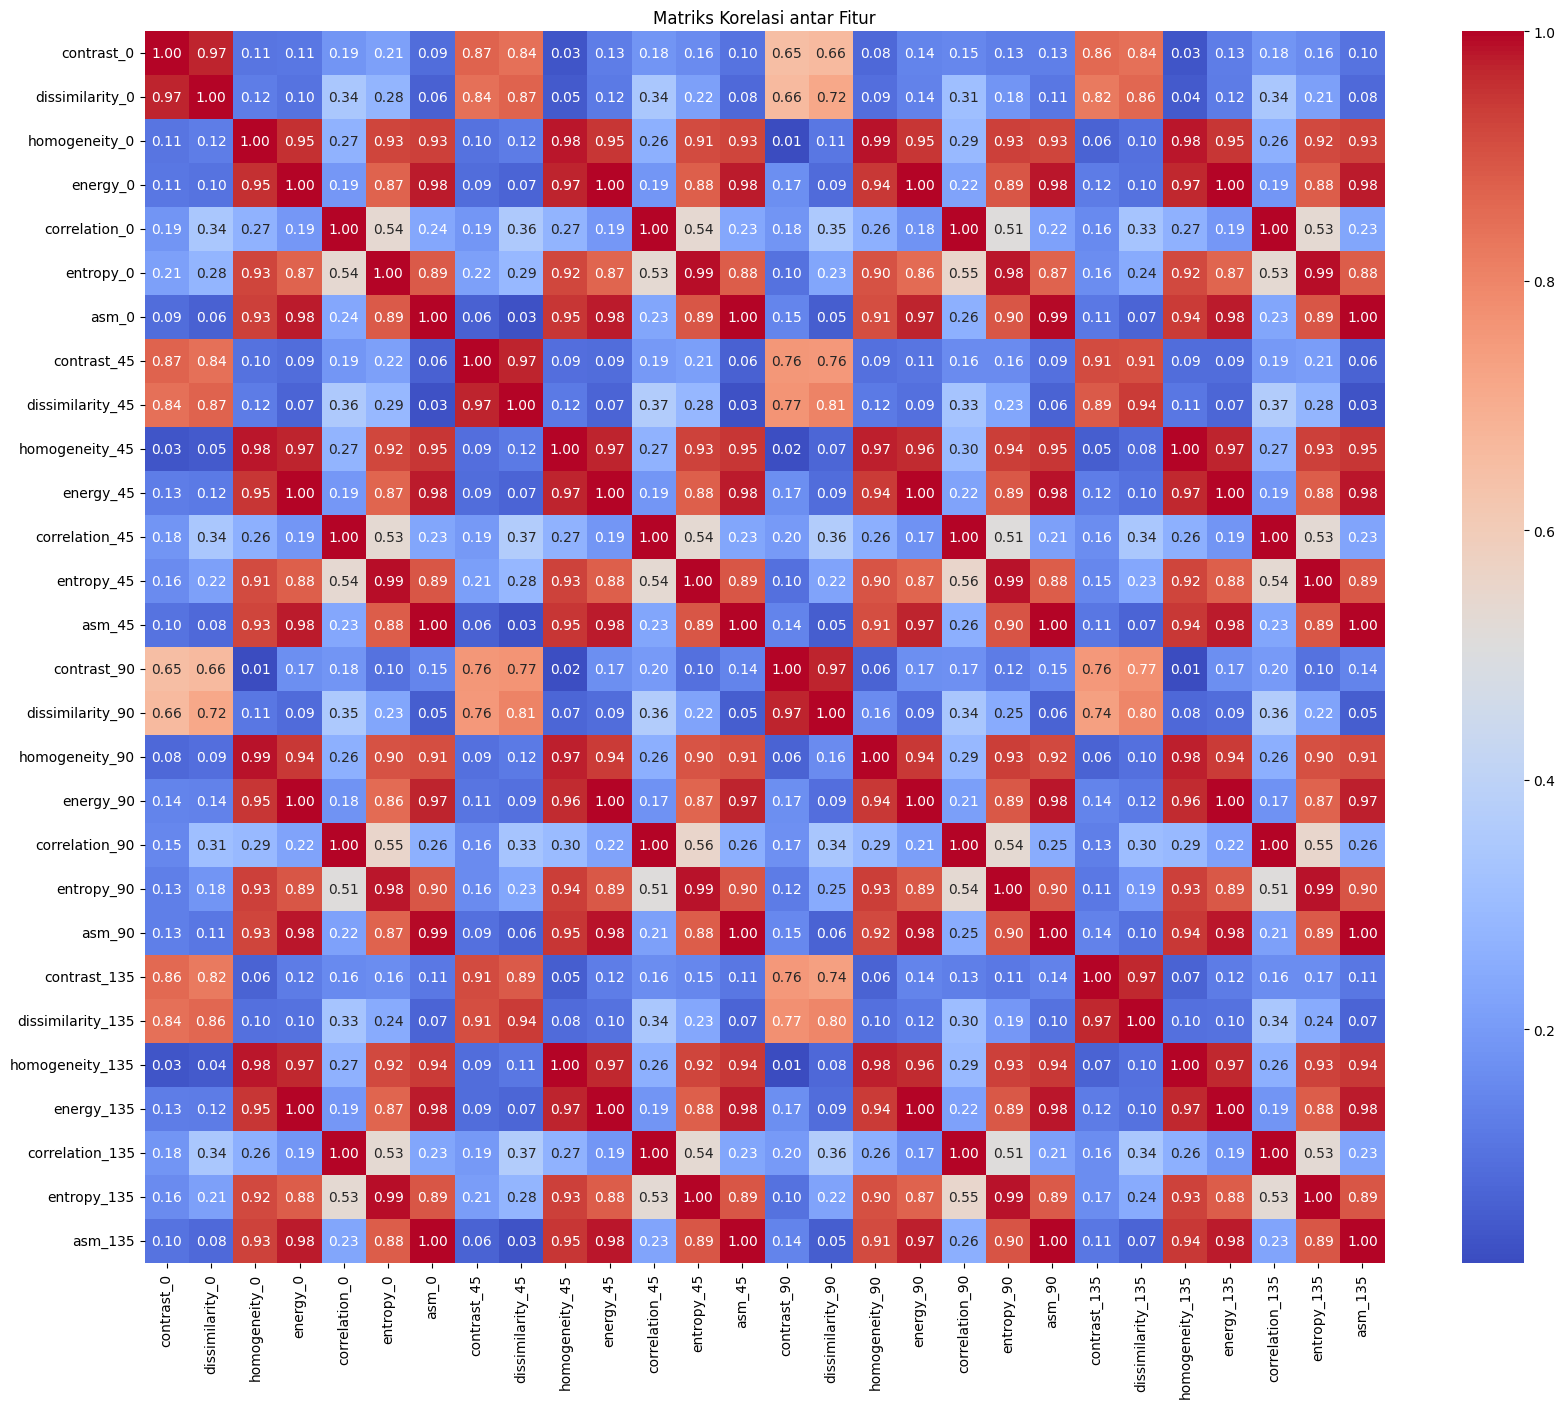

In [334]:
correlation_matrix = features_df.drop('label', axis=1).corr().abs()

plt.figure(figsize=(20, 16))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Matriks Korelasi antar Fitur')

plt.show()

In [335]:
features_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.9:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]

            features_to_drop.add(col2)

filtered_features_df = features_df.drop(columns=list(features_to_drop))

In [344]:
# filtered_features_df.to_csv('filtered 2.2 ekstraksi_fitur_sebelum.csv', index=False)

In [ ]:
# filtered_features_df = pd.read_csv('filtered 2.2 ekstraksi_fitur_sebelum.csv')

In [336]:
# filtered_features_df = features_df[['contrast_0', 'homogeneity_0', 'energy_0', 'correlation_0', 'entropy_0', 'label']]

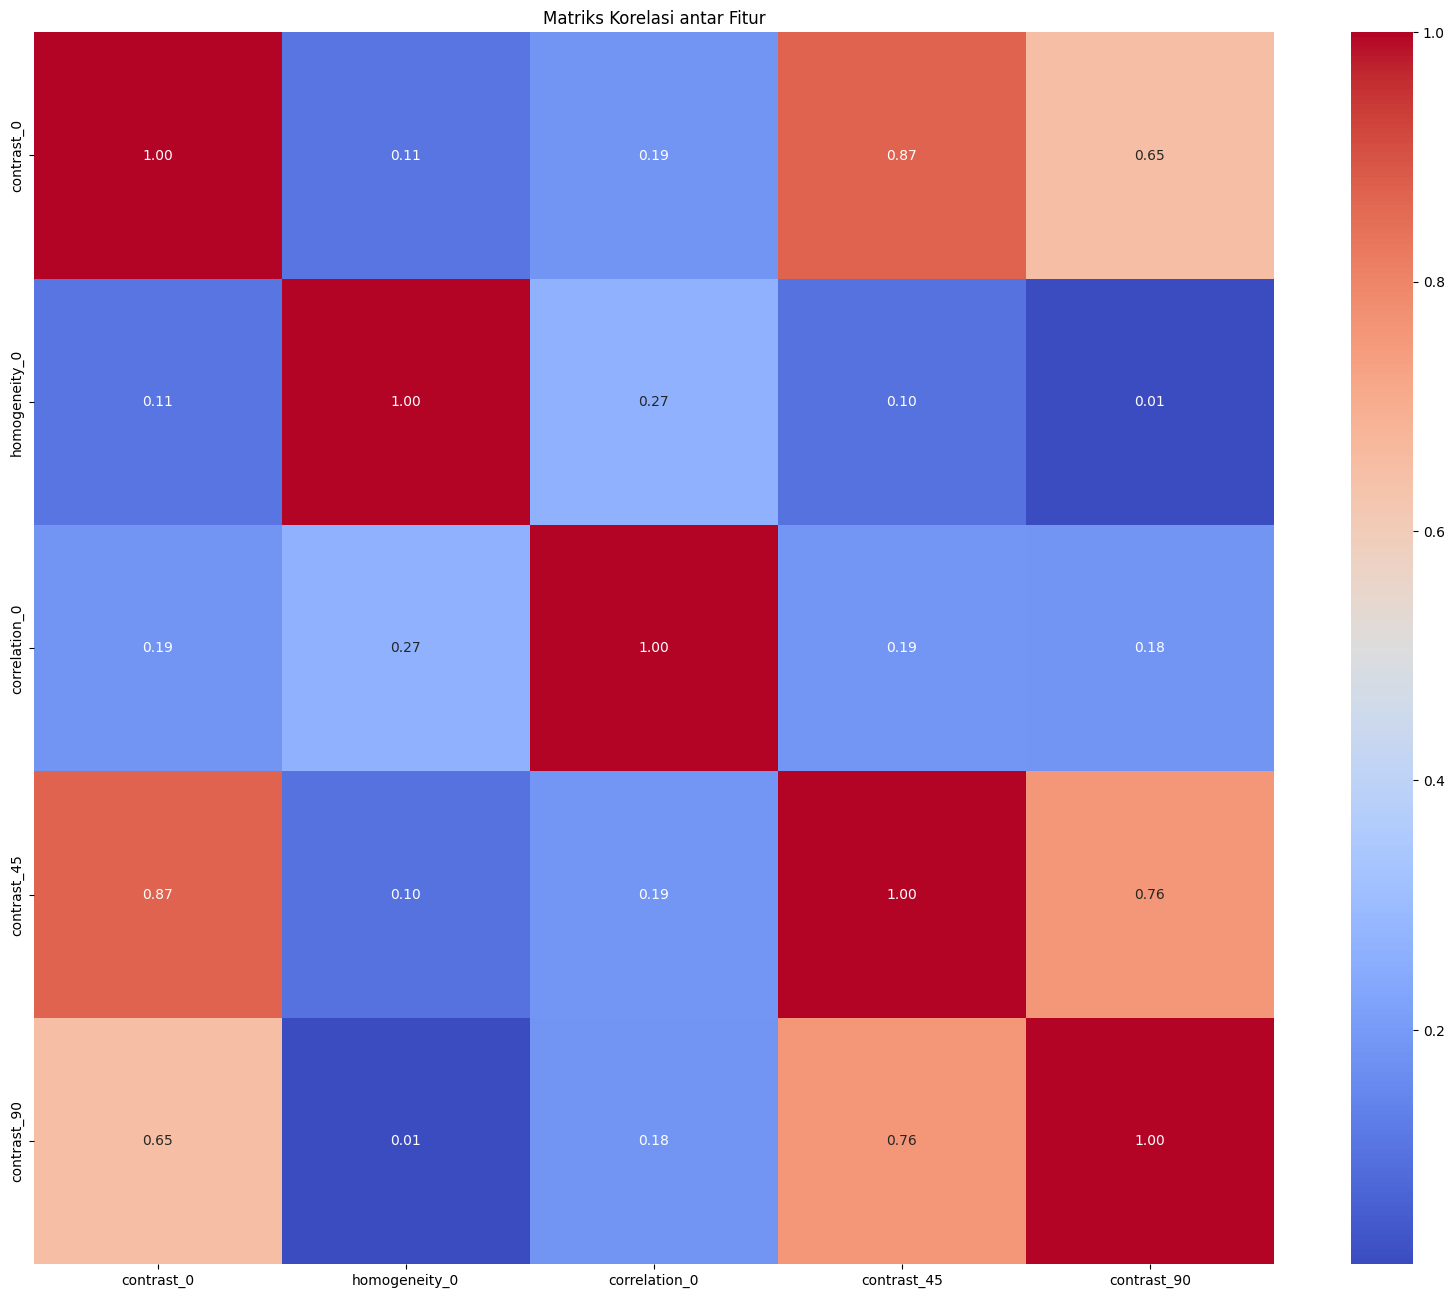

In [337]:
correlation_matrix_2 = filtered_features_df.drop('label', axis=1).corr().abs()

plt.figure(figsize=(20, 16))

sns.heatmap(correlation_matrix_2, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Matriks Korelasi antar Fitur')

plt.show()

In [338]:
XX = filtered_features_df.drop(columns=['label']).values
yy = filtered_features_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.20, random_state=42)

In [339]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [340]:
hasil_model = {
    'KNN': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'SVM': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'Random Forest': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
}

In [341]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True, zero_division=0)
hasil_model['KNN']['accuracy'].append(report_knn['accuracy'])
hasil_model['KNN']['precision'].append(report_knn['weighted avg']['precision'])
hasil_model['KNN']['recall'].append(report_knn['weighted avg']['recall'])
hasil_model['KNN']['f1_score'].append(report_knn['weighted avg']['f1-score'])

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)
hasil_model['SVM']['accuracy'].append(report_svm['accuracy'])
hasil_model['SVM']['precision'].append(report_svm['weighted avg']['precision'])
hasil_model['SVM']['recall'].append(report_svm['weighted avg']['recall'])
hasil_model['SVM']['f1_score'].append(report_svm['weighted avg']['f1-score'])

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
hasil_model['Random Forest']['accuracy'].append(report_rf['accuracy'])
hasil_model['Random Forest']['precision'].append(report_rf['weighted avg']['precision'])
hasil_model['Random Forest']['recall'].append(report_rf['weighted avg']['recall'])
hasil_model['Random Forest']['f1_score'].append(report_rf['weighted avg']['f1-score'])

df_hasil = pd.DataFrame(hasil_model).T
print(df_hasil)


                           accuracy             precision  \
KNN             [0.703076923076923]  [0.7035228420182507]   
SVM             [0.676923076923077]  [0.6773863550954485]   
Random Forest  [0.7203846153846154]  [0.7210002481152629]   

                             recall              f1_score  
KNN             [0.703076923076923]  [0.6997653666107396]  
SVM             [0.676923076923077]  [0.6729458121416542]  
Random Forest  [0.7203846153846154]  [0.7173616042098143]  


brightness
                           accuracy             precision  \
KNN            [0.8403846153846154]  [0.8401761919690797]   
SVM            [0.6988461538461539]  [0.7063718683398894]   
Random Forest                [0.89]  [0.8910863500380903]   

                             recall              f1_score  
KNN            [0.8403846153846154]  [0.8368941787851024]  
SVM            [0.6988461538461539]  [0.6827377363293593]  
Random Forest                [0.89]  [0.8886392459181172]  
brightness + sharpening + median + edge + minmax
                           accuracy             precision  \
KNN             [0.703076923076923]  [0.7035228420182507]   
SVM             [0.676923076923077]  [0.6773863550954485]   
Random Forest  [0.7203846153846154]  [0.7210002481152629]   

                             recall              f1_score  
KNN             [0.703076923076923]  [0.6997653666107396]  
SVM             [0.676923076923077]  [0.6729458121416542]  
Random Forest  [0.7203846153846154]  [0.7173616042098143]  

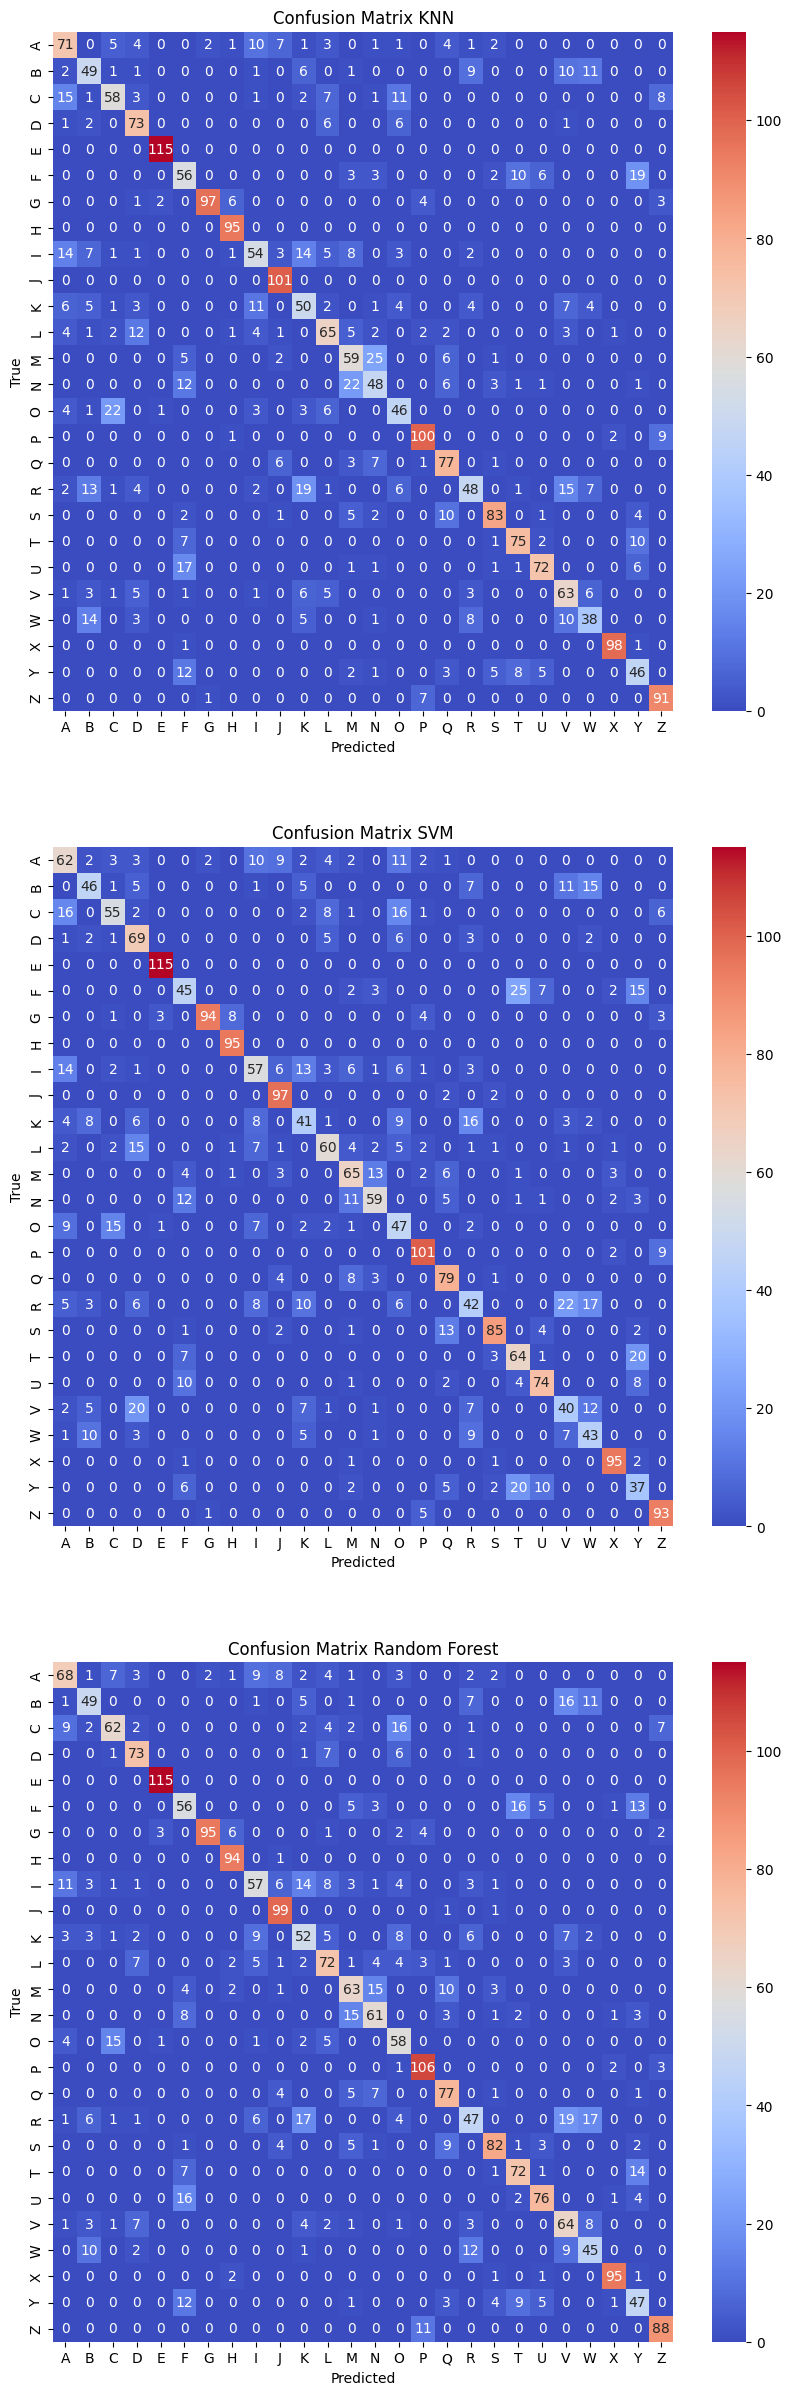

In [342]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

num_classes = len(np.unique(y_test))
labels = labels[:num_classes]

fig, axes = plt.subplots(3, 1, figsize=(10, 30))

sns.heatmap(cm_knn, annot=True, cmap='coolwarm', fmt='g', ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_title('Confusion Matrix KNN')
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_svm, annot=True, cmap='coolwarm', fmt='g', ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_title('Confusion Matrix SVM')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

sns.heatmap(cm_rf, annot=True, cmap='coolwarm', fmt='g', ax=axes[2], xticklabels=labels, yticklabels=labels)
axes[2].set_title('Confusion Matrix Random Forest')
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

plt.show()

In [343]:
#cross validation

XX = filtered_features_df.drop(columns=['label']).values
yy = filtered_features_df['label'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_x = {
    'KNN': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'SVM': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'Random Forest': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
}

for train_index, test_index in kf.split(XX):
    X_train, X_test = XX[train_index], XX[test_index]
    y_train, y_test = yy[train_index], yy[test_index]
    

    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    report_knn = classification_report(y_test, y_pred_knn, output_dict=True, zero_division=0)
    results_x['KNN']['accuracy'].append(report_knn['accuracy'])
    results_x['KNN']['precision'].append(report_knn['weighted avg']['precision'])
    results_x['KNN']['recall'].append(report_knn['weighted avg']['recall'])
    results_x['KNN']['f1_score'].append(report_knn['weighted avg']['f1-score'])
    
    
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    report_svm = classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)
    results_x['SVM']['accuracy'].append(report_svm['accuracy'])
    results_x['SVM']['precision'].append(report_svm['weighted avg']['precision'])
    results_x['SVM']['recall'].append(report_svm['weighted avg']['recall'])
    results_x['SVM']['f1_score'].append(report_svm['weighted avg']['f1-score'])
    
    
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
    results_x['Random Forest']['accuracy'].append(report_rf['accuracy'])
    results_x['Random Forest']['precision'].append(report_rf['weighted avg']['precision'])
    results_x['Random Forest']['recall'].append(report_rf['weighted avg']['recall'])
    results_x['Random Forest']['f1_score'].append(report_rf['weighted avg']['f1-score'])


average_results = {
    'KNN': {metric: np.mean(values) for metric, values in results_x['KNN'].items()},
    'SVM': {metric: np.mean(values) for metric, values in results_x['SVM'].items()},
    'Random Forest': {metric: np.mean(values) for metric, values in results_x['Random Forest'].items()}
}

df_results = pd.DataFrame(average_results).T
print(df_results)

               accuracy  precision    recall  f1_score
KNN            0.458077   0.450106  0.458077  0.445704
SVM            0.223538   0.222754  0.223538  0.164685
Random Forest  0.722154   0.721755  0.722154  0.719924


1. brightness
               accuracy  precision    recall  f1_score
KNN            0.361231   0.353963  0.361231  0.349592
SVM            0.289077   0.236440  0.289077  0.203668
Random Forest  0.893308   0.893547  0.893308  0.892544

2. brightness + sharpening + median + edge + minmax
               accuracy  precision    recall  f1_score
KNN            0.458077   0.450106  0.458077  0.445704
SVM            0.223538   0.222754  0.223538  0.164685
Random Forest  0.722154   0.721755  0.722154  0.719924
